<h4><b>RNA Regression utilizando biblioteca Pytorch</b></h4>
<p>Experimento com base de dados grande, utilizando toda base, sem cross_validation</p>

In [53]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
torch.__version__

'2.0.1'

In [2]:
np.random.seed(123)
torch.manual_seed(123)

<h4><b>Carregando dados</b></h4>

In [3]:
path = '/media/marcos/500GB/00_datasets/post_processing/post_processing_dataset.csv'
df = pd.read_csv(path)

In [4]:
df = df[[
    'line_category',
    'line_color',
    'station_initial_latitude',
    'station_initial_longitude',
    'station_final_latitude',
    'station_final_longitude',
    'distance',
    'average_speed_kh',
    'duration'
]]

In [5]:
df

,line_category,line_color,station_initial_latitude,station_initial_longitude,station_final_latitude,station_final_longitude,distance,average_speed_kh,duration
0,1,1,-25.406891,-49.252828,-25.433741,-49.270292,5100.000000,20.400000,900.000000
1,8,5,-25.433741,-49.270292,-25.396167,-49.358341,17300.000000,38.444444,1620.000000
2,1,1,-25.396167,-49.358341,-25.435187,-49.271813,11300.000000,24.214286,1680.000000
3,2,2,-25.435187,-49.271813,-25.436659,-49.273807,1100.000000,16.500000,240.000000
4,2,2,-25.436659,-49.273807,-25.435052,-49.275876,2000.000000,15.000000,480.000000
...,...,...,...,...,...,...,...,...,...
12367,7,6,-25.424410,-49.295560,-25.494404,-49.282068,10500.000000,25.200000,1500.000000
12368,6,5,-25.494404,-49.282068,-25.475952,-49.240087,6200.000000,26.571429,840.000000
12369,7,6,-25.475952,-49.240087,-25.459501,-49.271815,5100.000000,25.500000,720.000000
12370,3,3,-25.459501,-49.271815,-25.440706,-49.271456,2500.000000,25.000000,360.000000


<h4><b>Atribuindo valores as variáveis X e y</b></h4>

In [7]:
X = df.iloc[:,0:8].values
y = df.iloc[:,8].values

In [8]:
X.shape

(12372, 8)

In [9]:
y.shape

(12372,)

<h4><b>Convertendo em tensores Pytorch</b></h4>
<p>view: Redefine as dimensões</p>

In [10]:
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float).view(-1,1)

In [11]:
type(X)

torch.Tensor

<p>Confirmando se a variável y está em formato de matriz</p>

In [12]:
y.shape

torch.Size([12372, 1])

<h4><b>Divisão em treino e teste</b></h4>

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<h4><b>Construção do modelo da rede neural</b></h4>
<p>Efetuamos este cálculo visando inicializar a quantidade de neurônios nas camadas ocultas da rede neural.</p>
<p>(entradas + saidas) / 2</p>

In [14]:
(8+1)/2

4.5

<ul>
    <li>Entrada: 8</li>
    <li>Camada oculta: 4 neurônios</li>
    <li>Camada oculta: 4 neurônios</li>
    <li>Camada de saída 1 neurônios</li>
</ul>

<h4><b>Criando regressor</b></h4>

In [24]:
regressor = nn.Sequential(
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1)
)

<h4><b>Definindo Criterio</b></h4>
<p>Função de erro;</p>
<p>L1Loss equivale a métrica Mean Absolute Error (MAE).</p>

In [25]:
criterion = nn.L1Loss()

<h4><b>Definindo Otimizador</b></h4>
<p>Pode-se configurar learning rate, mas no momento utilizamos os valores default.</p>

In [26]:
optimizer = optim.Adam(regressor.parameters())

<h4><b>Criando base de dados no formato Pytorch</b></h4>

In [27]:
dataset = torch.utils.data.TensorDataset(X_train, y_train)

<h4><b>Criando Train Loader</b></h4>
<p>Configuramos batch_size com valor 32 por se tratar de uma base de dados maior;</p>
<p>Configuramos shuffle=True para os dados sempre estarem misturados.</p>
<p>Pode-se configurar opcionalmente, num_workers=4</p>

In [28]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

<h4><b>Treinamento do modelo</b></h4>
<p>Configurações iniciais caso estivermos utilizando GPU.</p>

In [29]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

<h4><b>Enviando processamento para o device</b></h4>

In [30]:
regressor.to(device)

Sequential(
  (0): Linear(in_features=8, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

<p>Utilizaremos 100 épocas</p>

In [31]:
loss_list = []
mae_list = []
mse_list = []
rmse_list = []
r2_list = []

for epoch in range(1000):
    running_mae = 0.
    running_mse = 0.
    running_rmse = 0.
    running_loss = 0.
                                    
    # train_loader contém os dados em batchs
    for i, data in enumerate(train_loader):
        
        # Pegar 32 features previsores e 32 duration e envia para processamento
        inputs, labels = data
                                    
        # Caso utilizassemos gpu, os enviados dos dados serão enviados
        inputs, labels = inputs.to(device), labels.to(device)
                                    
        # Zerando os gradientes a cada vez que passa pelo for
        optimizer.zero_grad()
                                    
        # Fazendo as previsões, função forward passa os dados para frente
        # Nesta variável teremos o resultado da última camada
        outputs = regressor.forward(inputs)
                                    
        # Calculando valor do erro
        # Fl1_loss calcula o valor do mean absolute error (MAE)
        # .item() acessa somente o valor do erro
        # mae = F.l1_loss(outputs, labels).item()
        mae = F.l1_loss(outputs, labels, reduction='sum').item()
        mse = F.mse_loss(outputs, labels, reduction='sum').item()
        rmse = np.sqrt(mse)
                                    
        # Histórico de valores
        running_mae += mae
        running_mse += mse
        running_rmse += rmse
                                    
        # Calculando o erro no treinamento
        # Este erro vamos utilizar para otimizador
        loss = criterion(outputs, labels)
                                    
        # Inicia processo de backpropagation
        # Volta a estrutura da rede neural, fazendo a atualização dos pesos
        loss.backward()
                                    
        # Atualiza os pesos
        optimizer.step()
                                    
        # Atualizando a variável running_loss
        running_loss += loss.item()
                                    
        # print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:06.2f} - MAE {:06.2f}'.format(
        #     epoch+1,
        #     i+1,
        #     len(y)//32, # // para não pegar valores com vírgula
        #     loss,
        #     mae
        # ))

        # print(f'epoch: {epoch+1}, loop: {i+1} de {len(y)}, mae: {mae:.4f}')

    mae_res = running_mae/len(train_loader)
    mse_res = running_mse/len(train_loader)
    rmse_res = running_rmse/len(train_loader)
    loss_res = running_loss/len(train_loader)
    
    rss = torch.sum((labels - outputs) ** 2).item()
    tss = torch.sum((labels - labels.mean()) ** 2).item()
    r2_score = 1 - (rss / tss)

    mae_list.append(mae_res)
    mse_list.append(mse_res)
    rmse_list.append(rmse_res)
    loss_list.append(loss_res)

    r2_list.append(r2_score)
    
    print(f'epoch: {epoch+1}, mae: {mae_res:.4f}, mse: {mse_res:.4f}, rmse: {rmse_res:.4f}, loss: {loss_res:.4f}, r2_score: {r2_score:.4f}')

epoch: 1, mae: 41895.0152, mse: 64954689.6935, rmse: 8034.9246, loss: 1311.8519, r2_score: -3.9156
epoch: 2, mae: 23276.3208, mse: 27541356.3992, rmse: 4633.4715, loss: 728.2672, r2_score: 0.4731
epoch: 3, mae: 9163.9643, mse: 4926593.2196, rmse: 2173.6649, loss: 286.9839, r2_score: 0.2165
epoch: 4, mae: 9027.3004, mse: 4867757.4879, rmse: 2164.9016, loss: 282.6144, r2_score: 0.8191
epoch: 5, mae: 8894.1670, mse: 4734189.4139, rmse: 2135.7799, loss: 278.5448, r2_score: 0.8098
epoch: 6, mae: 8766.9998, mse: 4617261.4435, rmse: 2102.8095, loss: 274.8059, r2_score: -0.2310
epoch: 7, mae: 8635.1240, mse: 4490478.0869, rmse: 2076.0732, loss: 270.4034, r2_score: 0.3504
epoch: 8, mae: 8508.7236, mse: 4369270.0323, rmse: 2048.8098, loss: 266.7263, r2_score: 0.3501
epoch: 9, mae: 8376.3380, mse: 4216732.5887, rmse: 2011.8726, loss: 262.4625, r2_score: 0.5590
epoch: 10, mae: 8243.1643, mse: 4120433.9270, rmse: 1989.2039, loss: 258.0605, r2_score: 0.8053
epoch: 11, mae: 8094.2761, mse: 3937081.09

<h4><b>Gráfico das métricas</b></h4>

In [32]:
def plot_metric_graph(metric, color, metric_list):
    plt.figure(figsize=(6,4))
    plt.plot(metric_list, label=metric, color=color)
    plt.xlabel('Épocas')
    plt.ylabel('Valores das Métricas')
    plt.title(f'Métrica {metric} ao longo das épocas')
    plt.legend()
    plt.grid(True)
    plt.show()

def plt_all_metrics_graph(mae, mse, rmse, loss, r2_score):
    plt.figure(figsize=(6,4))
    plt.plot(mae, label='MAE', color='blue')
    plt.plot(mse, label='MSE', color='green')
    plt.plot(rmse, label='RMSE', color='orange')
    plt.plot(loss, label='Loss', color='red')
    plt.plot(loss, label='R2 Score', color='black')
    plt.xlabel('Épocas')
    plt.ylabel('Valores das Métricas')
    plt.title('Métricas de treinamento ao longo das épocas')
    plt.legend()
    plt.grid(True)
    plt.show()

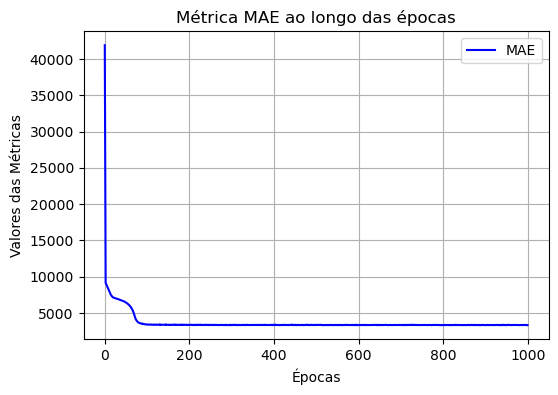

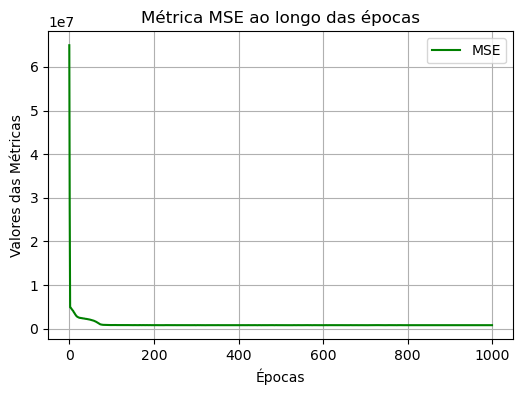

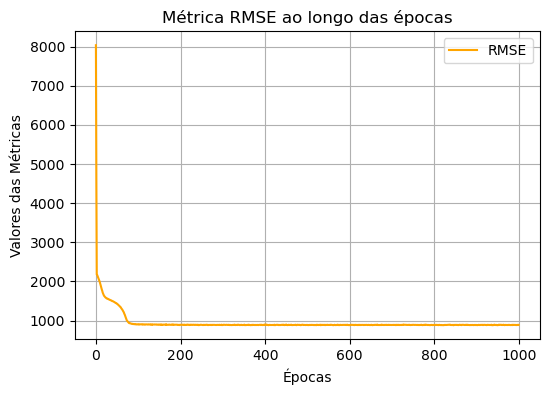

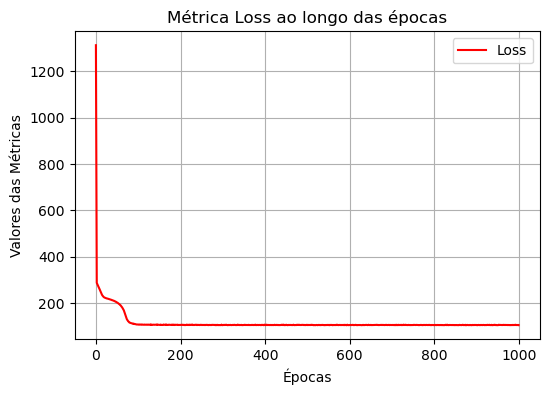

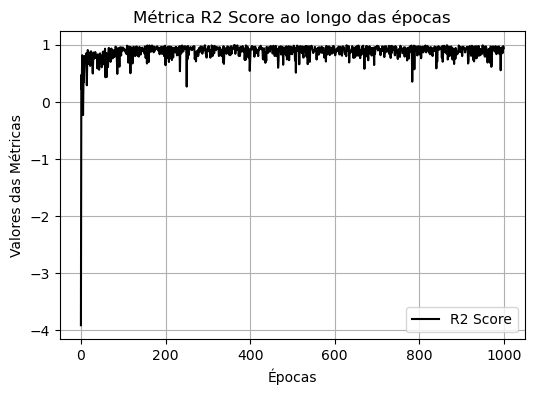

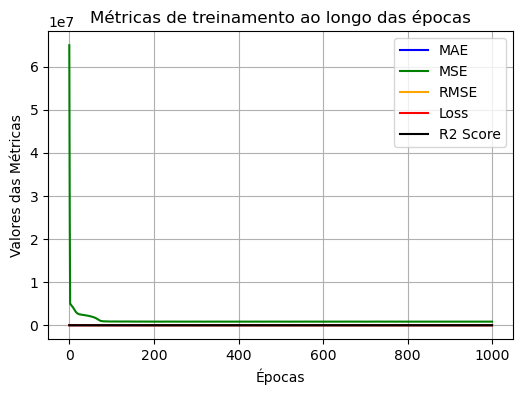

In [33]:
plot_metric_graph('MAE', 'blue', mae_list)
plot_metric_graph('MSE', 'green', mse_list)
plot_metric_graph('RMSE', 'orange', rmse_list)
plot_metric_graph('Loss', 'red', loss_list)
plot_metric_graph('R2 Score', 'black', r2_list)
plt_all_metrics_graph(mae_list, mse_list, rmse_list, loss_list, r2_list)

<h4><b>Avaliação do modelo</b></h4>
<p>Colocando rede neural em modo de avaliação</p>

In [34]:
regressor.eval()

Sequential(
  (0): Linear(in_features=8, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

<h4><b>Gerando predições - dados treino</b></h4>

In [35]:
predicts_train = regressor.forward(X_train.to(device)).detach().cpu().numpy()
predicts_train

array([[2463.277  ],
       [1016.24634],
       [2544.9917 ],
       ...,
       [1187.5096 ],
       [ 618.6809 ],
       [1092.484  ]], dtype=float32)

In [36]:
y_train

tensor([[2460.],
        [ 960.],
        [2220.],
        ...,
        [1140.],
        [ 360.],
        [1020.]])

<h4><b>Calculando métricas de erro - base treino</b></h4>

In [40]:
mae_train = mean_absolute_error(y_train, predicts_train)
mse_train = mean_squared_error(y_train, predicts_train)
rmse_train = np.sqrt(mse_train)

print(f'MAE: {mae_train:.4f}')
print(f'MSE: {mse_train:.4f}')
print(f'RMSE: {rmse_train:.4f}')

MAE: 113.5379
MSE: 33355.3438
RMSE: 182.6345


<h4><b>Calculando r2 Score - base treino</b></h4>

In [55]:
r2_score_train = r2_score(y_train, predicts_train)
print(f'R2 Score: {r2_score_train:.4f}')

R2 Score: 0.8878


<h4><b>Gerando predições - dados teste</b></h4>

In [56]:
predicts_test = regressor.forward(X_test.to(device)).detach().cpu().numpy()
predicts_test

array([[1061.4247],
       [1288.4858],
       [1558.0795],
       ...,
       [ 350.655 ],
       [2300.5776],
       [1781.5922]], dtype=float32)

In [57]:
y_test

tensor([[1020.],
        [1260.],
        [1500.],
        ...,
        [ 840.],
        [2340.],
        [1680.]])

<h4><b>Calculando métricas de erro - base teste</b></h4>

In [58]:
mae_test = mean_absolute_error(y_test, predicts_test)
mse_test = mean_squared_error(y_test, predicts_test)
rmse_test = np.sqrt(mse_test)

print(f'MAE: {mae_test:.4f}')
print(f'MSE: {mse_test:.4f}')
print(f'RMSE: {rmse_test:.4f}')

MAE: 112.6421
MSE: 31332.3613
RMSE: 177.0095


<h4><b>Calculando r2 Score - base teste</b></h4>

In [59]:
r2_score_test = r2_score(y_test, predicts_test)
print(f'R2 Score: {r2_score_test:.4f}')

R2 Score: 0.8918
